In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import os

In [2]:
nsims = 100
nside = 256
iband = 2
color = 'white'
flat = False
npix = hp.nside2npix(nside)
lmax = 3*nside-1
ls = np.arange(lmax+1)
pureE = True

In [3]:
mask = hp.ud_grade(hp.read_map("data/mask_apodized.fits"), nside_out=nside)
if flat:
    nhits = np.ones_like(mask)
else:
    nhits = hp.read_map(f"data/nhits_ns{nside}.fits.gz")

In [4]:
maskb = (mask > 0).astype(float)

In [5]:
b = nmt.NmtBin.from_nside_linear(nside, nlb=10)
f = nmt.NmtField(mask, None, spin=2, purify_b=True, purify_e=pureE)
w = nmt.NmtWorkspace.from_fields(f, f, b)
f_np = nmt.NmtField(mask, None, spin=2)
w_np = nmt.NmtWorkspace.from_fields(f_np, f_np, b)
leff = b.get_effective_ells()

In [6]:
os.system('mkdir -p data/cls')
cls = []
pcls = []
cls_np = []
pcls_np = []
for i in range(nsims):
    seed = 1000 + i
    if pureE:
        predir = 'data/cls'
    else:
        predir = 'data/cls/cls_nopureE'
    if flat:
        fname = f'{predir}/cls_noise_flat_{color}_band{iband}_{seed}.npz'
    else:
        fname = f'{predir}/cls_noise_{color}_band{iband}_{seed}.npz'
    if os.path.isfile(fname):
        d = np.load(fname)
        cl = d['cl']
        pcl = d['pcl']
        cl_np = d['cl_np']
        pcl_np = d['pcl_np']
    else:
        print(seed)
        if flat:
            q, u = hp.read_map(f'data/sims/sim_noise_flat_{color}_band{iband}_{seed}.fits.gz',
                               field=None)
        else:
            q, u = hp.read_map(f'data/sims/sim_noise_{color}_band{iband}_{seed}.fits.gz',
                               field=None)
        f = nmt.NmtField(mask, [q*maskb, u*maskb], purify_b=True, purify_e=pureE)
        pcl = nmt.compute_coupled_cell(f, f)
        cl = w.decouple_cell(pcl)
        f = nmt.NmtField(mask, [q*maskb, u*maskb])
        pcl_np = nmt.compute_coupled_cell(f, f)
        cl_np = w_np.decouple_cell(pcl)
        np.savez(fname, cl=cl, pcl=pcl, cl_np=cl_np, pcl_np=pcl_np)
    cls.append(cl)
    pcls.append(pcl)
    cls_np.append(cl_np)
    pcls_np.append(pcl_np)
cls = np.array(cls)
pcls = np.array(pcls)
cls_np = np.array(cls_np)
pcls_np = np.array(pcls_np)

In [7]:
sigma_map = np.zeros_like(mask)
good = nhits > 0
sigma_map[good] = 1/np.sqrt(nhits[good])
mask_noise = mask*sigma_map

1.8364676 14811.159376117144 32.91740230449427 1.0


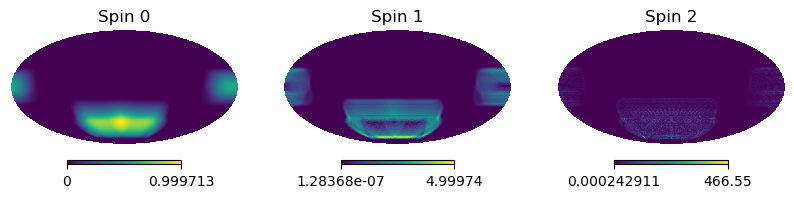

In [8]:
def get_beta(ll, s, inv=False):
    ls = np.atleast_1d(ll)
    beta = np.ones_like(ls)
    for n in range(1, 2*s+1):
        beta *= ls-s+n

    bad_ell = beta <= 0
    beta[bad_ell] = 1000
    beta = np.sqrt(beta)
    if not inv:
        beta = 1/beta
    beta[bad_ell] = 0

    if np.ndim(ll) == 0:
        beta = np.squeeze(beta)
    return beta

def spin_mask(mask, spin):
    mask_alm = hp.map2alm(mask)
    beta = get_beta(ls, spin, inv=True)
    mask_alm = -hp.almxfl(mask_alm, beta)
    return hp.alm2map_spin([mask_alm, 0*mask_alm], nside, spin, lmax)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
mask_0 = mask
mask_1 = np.sqrt(np.sum(np.array(spin_mask(mask, 1))**2, axis=0))
mask_2 = np.sqrt(np.sum(np.array(spin_mask(mask, 2))**2, axis=0))
plt.axes(axes[0]); hp.mollview(mask_0, hold=True, title='Spin 0')
plt.axes(axes[1]); hp.mollview(mask_1, hold=True, title='Spin 1')
plt.axes(axes[2]); hp.mollview(mask_2, hold=True, title='Spin 2')
avg_s2_w02 = np.mean((sigma_map*mask_0)**2)
avg_s2_w12 = np.mean((sigma_map*mask_1)**2)
avg_s2_w22 = np.mean((sigma_map*mask_2)**2)
avg_w02 = np.mean(mask_0**2)
beta_2 = get_beta(ls, 2)
inv_beta_0 = get_beta(ls, 0, inv=True)
inv_beta_1 = get_beta(ls, 1, inv=True)
inv_beta_2 = get_beta(ls, 2, inv=True)
rescale = avg_s2_w02/avg_w02
shape_prediction = (1**2 * (beta_2 * inv_beta_0)**2 * avg_s2_w22/avg_s2_w02 +  # n=0
                    2**2 * (beta_2 * inv_beta_1)**2 * avg_s2_w12/avg_s2_w02 +  # n=0
                    1**2 * (beta_2 * inv_beta_2)**2 * avg_s2_w02/avg_s2_w02)
print(rescale, avg_s2_w22/avg_s2_w02, avg_s2_w12/avg_s2_w02, avg_s2_w02/avg_s2_w02)

In [9]:
def read_cls():
    d = np.load("data/nls.npz")
    ls = d['ls']
    if color == 'white':
        nl = d['nls_white'][iband]
    else:
        nl = d['nls'][iband]
    nl[:2] = 0
    return ls, nl


ls, nl = read_cls()
nl *= rescale

pcl_pred = w.couple_cell(np.array([nl, 0*nl, 0*nl, nl]))
pcl_pred_mine = pcl_pred.copy()
if pureE:
    pcl_pred_mine[0] = shape_prediction * nl * avg_w02
pcl_pred_mine[3] = shape_prediction * nl * avg_w02
cl_pred = w.decouple_cell(pcl_pred)
cl_pred_mine = w.decouple_cell(pcl_pred_mine)
pcl_np_pred = w_np.couple_cell(np.array([nl, 0*nl, 0*nl, nl]))
cl_np_pred = w_np.decouple_cell(pcl_np_pred)

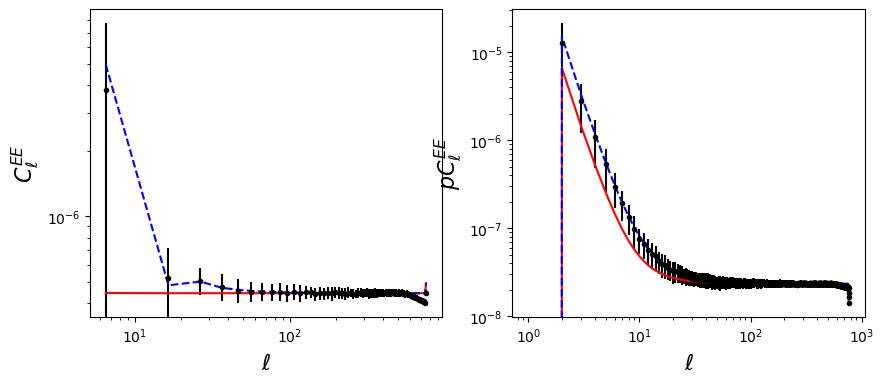

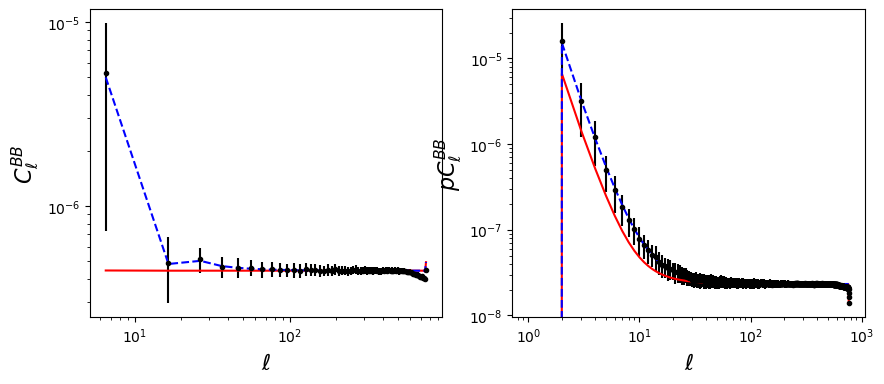

In [10]:
comb = ['EE', 'EB', 'BE', 'BB']
for icl in [0, 3]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    # Decoupled
    ax = axes[0]
    ax.errorbar(leff, np.mean(cls[:, icl, :], axis=0),
                 yerr=np.std(cls[:, icl, :], axis=0), fmt='k.')
    ax.plot(leff, cl_pred[icl], 'r-')
    ax.plot(leff, cl_pred_mine[icl], 'b--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$', fontsize=16)
    ax.set_ylabel(r'$C_\ell^{'+comb[icl]+'}$', fontsize=16)
    
    # Coupled
    ax = axes[1]
    ax.errorbar(ls, np.mean(pcls[:, icl, :], axis=0),
                 yerr=np.std(pcls[:, icl, :], axis=0), fmt='k.')
    ax.plot(ls, pcl_pred[icl], 'r-')
    ax.plot(ls, pcl_pred_mine[icl], 'b--')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$', fontsize=16)
    ax.set_ylabel(r'$pC_\ell^{'+comb[icl]+'}$', fontsize=16)


In [11]:
n_ell = len(leff)
f = nmt.NmtField(mask, None, spin=2, purify_b=True, purify_e=pureE)
ww = nmt.NmtWorkspace.from_fields(f, f, b)
fn = nmt.NmtField(mask_noise/np.sqrt(rescale), None, spin=2)
#cls_4cov = pcl_pred/np.mean(mask**2)
#cls_4cov = pcl_pred_mine/np.mean(mask**2)
cls_4cov = np.mean(pcls, axis=0)/np.mean(mask**2)
cw = nmt.NmtCovarianceWorkspace.from_fields(fn, fn)

cov_sp2 = nmt.gaussian_covariance(cw, 2, 2, 2, 2,
                                  cls_4cov, cls_4cov,
                                  cls_4cov, cls_4cov,
                                  ww).reshape([n_ell, 4, n_ell, 4])

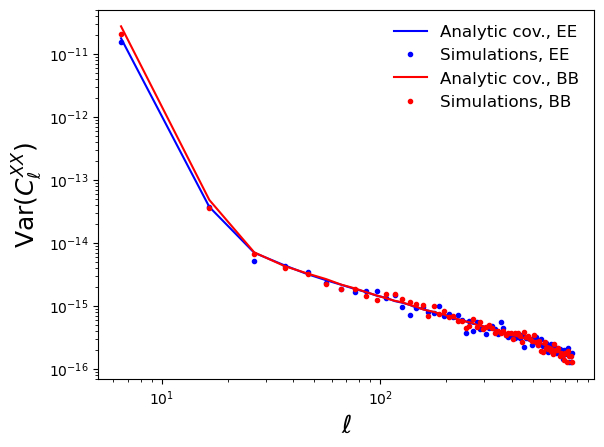

In [12]:
plt.figure()
plt.plot(leff, np.diag(cov_sp2[:, 0, :, 0]), 'b-', label='Analytic cov., EE')
plt.plot(leff, np.std(cls[:, 0, :], axis=0)**2, 'b.', label='Simulations, EE')
plt.plot(leff, np.diag(cov_sp2[:, 3, :, 3]), 'r-', label='Analytic cov., BB')
plt.plot(leff, np.std(cls[:, 3, :], axis=0)**2, 'r.', label='Simulations, BB')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=18)
plt.ylabel(r'${\rm Var}(C^{XX}_\ell)$', fontsize=18)
plt.legend(frameon=False, fontsize=12)